In [66]:
import numpy as np
import pandas as pd
import pymc3 as pm
from matplotlib import pyplot as plt
%matplotlib inline

David Diaz  
SEFS 590F (Bayesian Models) - Winter 2016-17

## Homework 6

### 1. For the following questions, read the Kéry et al. 2005 article about the mallard data and the model.

#### a. After reading the article, what would you expect the relationships between mallard abundance and elevation, forest cover, and survey length to be? Create a simple scatter plot of each and place a smooth line through the data. How do the patterns in the raw data compare with what you thought? (Please provide the graphs and your comments).

I would expect mallard abundance to decline with increasing elevation, to decline with increasing forest cover, and to increase with increasing survey length.

In [2]:
# to drop rows with missing values
# mallard = pd.read_csv('mallard.csv')
# cols = ['y1', 'y2', 'y3', 'elev', 'length', 'forest', 'date1', 'date2', 'date3']
# mallard = mallard[cols].dropna() # drop all rows with NAs in any column

In [81]:
# keeps all rows with missing values
mallard = pd.read_csv('mallard.csv')#.dropna(subset=['elev', 'length', 'forest'])
cols = ['y1', 'y2', 'y3', 'elev', 'length', 'forest', 'date1', 'date2', 'date3']
mallard = mallard[cols]

In [ ]:
# shorthand for easier typing
y1, y2, y3 = mallard.y1, mallard.y2, mallard.y3
elev, length, forest = mallard.elev, mallard.length, mallard.forest
date1, date2, date3 = mallard.date1, mallard.date2, mallard.date3
mallard.head()

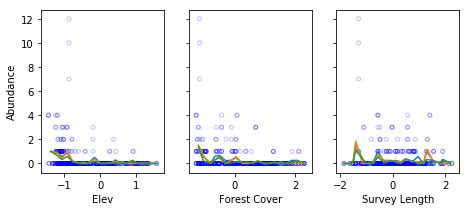

In [4]:
# make some graphs
plt.figure(figsize=(7.5,3))
ax1 = plt.subplot(131, xlabel="Elev", ylabel="Abundance") # first figure
ax2 = plt.subplot(132, xlabel="Forest Cover") # second figure
ax3 = plt.subplot(133, xlabel="Survey Length") # third figure
for y in [y1, y2, y3]:
    # scatter plots
    ax1.scatter(elev, y, facecolors='none', edgecolors='b', alpha=0.25, s=15)
    ax2.scatter(forest, y, facecolors='none', edgecolors='b', alpha=0.25, s=15)
    ax3.scatter(length, y, facecolors='none', edgecolors='b', alpha=0.25, s=15)
    # smoothed lines as moving average of abundance with 20 bins for each covariate...
    ax1.plot(elev.groupby(pd.cut(elev,20)).median(), y.groupby(pd.cut(elev,20)).mean())
    ax2.plot(forest.groupby(pd.cut(forest,20)).median(), y.groupby(pd.cut(forest,20)).mean())
    ax3.plot(length.groupby(pd.cut(length,20)).median(), y.groupby(pd.cut(length,20)).mean())
ax2.yaxis.set_ticklabels([]), ax3.yaxis.set_ticklabels([])
plt.show()

Abundance in the raw data appears to be dominated by many zero counts (zero-inflated), which draws the running average of abundance down to near-zero across the range of all three of these covariates. Ignoring zero-counts, abundance appears to decline as elevation increases and as forest cover increases.

#### b. In class, we defined an N-mixture model for the mallard data such that:
$$y_{it}\sim Binomial(N_i,\phi)$$
$$N_i\sim Poisson(\lambda)$$
#### Include elevation, forest cover, and survey length as covariates for abundance $(N_i)$. You can add the data by loading the R package ```unmarked```, then attaching the data ```data(mallard)```. The observed number of mallards are in the object ```mallard.y```. The covariates are in the object ```mallard.site```. Report the parameter estimates for each of your covariates.

In [76]:
# maybe need to transpose dataframe to have same shape as each covariate series
observations = mallard[['y1','y2','y3']].T
num_transects = len(mallard)
# i = mallard.index.values # an index of transects, do we need this?

Assigned NUTS to prob_logodds_
Assigned NUTS to b0
Assigned NUTS to b1
Assigned NUTS to b2
Assigned NUTS to b3
Assigned Metropolis to Ni
Assigned Metropolis to Y_obs_missing
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 589.27it/s]


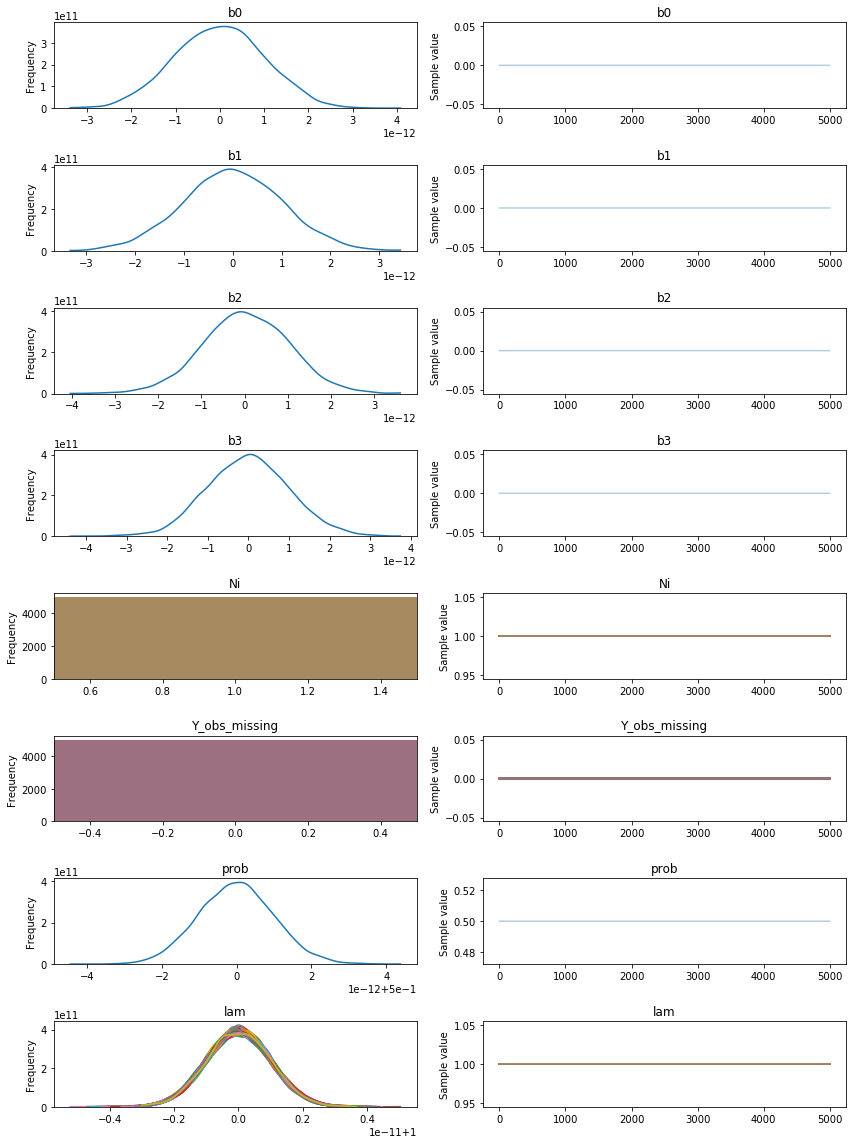

In [80]:
with pm.Model() as mallard_model:
    # priors
    # detection probability considered constant across all transects and plots
    prob = pm.Beta('prob', alpha=1, beta=1)
    # priors for deterministic linear model of local abundance at a transect 
    # that applies to all plots within a transect
    b0 = pm.Normal('b0', mu=0, sd=10) # intercept
    b1 = pm.Normal('b1', mu=0, sd=10) # elevation
    b2 = pm.Normal('b2', mu=0, sd=10) # forest cover
    b3 = pm.Normal('b3', mu=0, sd=10) # survey length
    
    # linear model of local abundance using log link
    lam = pm.Deterministic('lam', pm.math.exp(b0 + b1*elev + b2*forest + b3*length))
    # alternative would be indexing b params if they are specified as
    # b = pm.Normal('b', mu=0, sd=10, shape=4)... then lam would be defined as...
    # lam = pm.Deterministic('lam', pm.math.exp(b[0] + b[1]*elev + b[2]*forest + b[3]*length))
    
    # likelihood of observations
    # Ni is abundance at a transect, with binomial distribution across 
    # the 1-3 plots observed within a transect
    Ni = pm.Poisson('Ni', mu=lam[i], shape=num_transects)
    Y_obs = pm.Binomial('Y_obs', n=Ni, p=prob, observed=observations)
    
    # starting values
    # start_vals = {b0:-1.2, b1:1.4, b2:0.6, b3:0.2, prob:0.9}
    # get some inference, use default step functions for each parameter
    trace = pm.sample(draws=5000, init='ADVI', n_init=10000) #, step=pm.Metropolis())
    
    plt.figure(figsize=(7, 7))
    pm.traceplot(trace) # leave out first 100 draws as burn-in
    plt.tight_layout()

#### c. Interpret the results in your own words. Would you say that the results (i.e., the parameter estimates) are consistent with what you thought in part a? What is the relationship between abundance and length, does this make sense?

### 2. Now extend the model to also include date as covariate on detection $(\phi)$. The data for the dates are included in the object ```mallard.obs```. Create a table that describes the parameter estimates from this model and describe if the parameter estimates for elevation, forest cover, and length are affected by adding the covariate on detection. What is the estimate of detection and provide an interpretation of the results?  
#### [Hint: most sites are sampled 3 times, but some are only 1or 2. JAGS will not accept NA values for covariates, so you will need to figure out how to remove the surveys that were not sampled.] 

### 3. In this question, you will start working on posterior predictive checks.

#### a. Write a function to simulate data from a Negative Binomial distribution with $\lambda=4$, $\theta=0.5$ and simulate a dataset with $n=100$ data points.

In [82]:
lam, theta, num_samples = 4, 0.5, 100
def gen_negBinom(lamb, theta, num_samples):
    size = lamb 
    scale= (1-theta)/theta
    print('For the Gamma, alpha: ', size,'beta: ',1/scale, 'mean: ', size*scale)
    gamma = np.random.gamma(shape=size, scale=scale, size=num_samples)
    return np.random.poisson(lam=gamma)
data = gen_negBinom(lamb=lam, theta=theta, num_samples=num_samples)

For the Gamma, alpha:  4 beta:  1.0 mean:  4.0


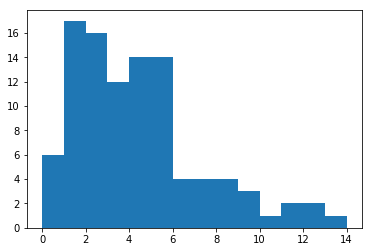

In [141]:
plt.figure()
plt.hist(data, bins=max(data))
plt.show()

#### b. Using the dataset you created, fit 3 models to the data in JAGS.
$y_i\sim Negative Binomial(\lambda,\theta)$ *note that this is not the parameterization that jags uses, you will need to look at the manual to moment match this with the version R uses.  
$y_i\sim Poisson(\lambda)$  
$y_i\sim Zero-inflated Poisson(\lambda,p)$

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -434.17: 100%|████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8327.78it/s]
Finished [100%]: Average ELBO = -448.94
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 420.69it/s]


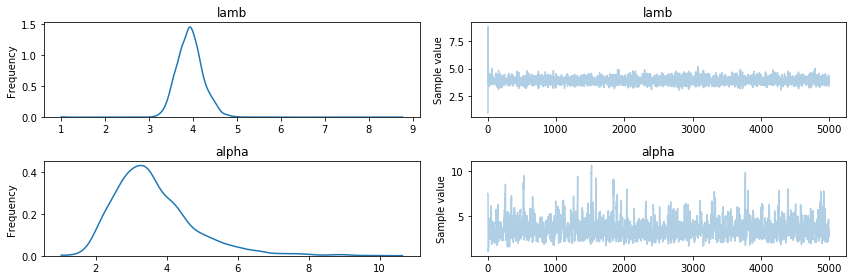

In [142]:
# fitted as a Negative Binomial
with pm.Model() as negbinom_model:
    # vague priors for unknown model parameters
    lamb = pm.Gamma('lamb', alpha=0.001, beta=0.001)
    alpha = pm.Uniform('alpha', lower=0, upper=15)
    
    # likelihood
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lamb, alpha=alpha, observed=data)
    # pymc3 paramaterizes the negative binomial with lambda of poisson and shape of gamma
    
    # inference
    start_vals = {lamb: 1, theta: 0.5}
    neg_trace = pm.sample(draws=5000, start=start_vals, n_init=1000, progressbar=True)
    
    # visualize the trace
    plt.figure(figsize=(7, 7))
    pm.traceplot(neg_trace)
    plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -520.19: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12978.23it/s]
Finished [100%]: Average ELBO = -514.81
100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1831.62it/s]


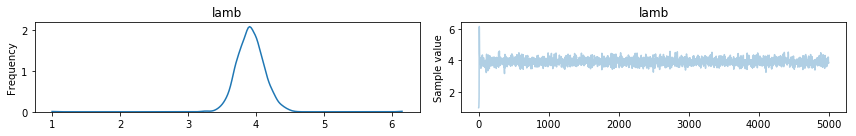

In [105]:
# fitted as a Poisson
with pm.Model() as poisson_model:
    # vague priors for unknown model parameters
    lamb = pm.Gamma('lamb', alpha=0.001, beta=0.001)
    
    # likelihood
    Y_obs = pm.Poisson('Y_obs', mu=lamb, observed=data)
    
    # inference
    start_vals = {lamb: 1}
    pois_trace = pm.sample(draws=5000, start=start_vals, n_init=1000, progressbar=True)
    
    # visualize the trace
    plt.figure(figsize=(7, 7))
    pm.traceplot(pois_trace)
    plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -584.55: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11103.86it/s]
Finished [100%]: Average ELBO = -569.67
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 300.25it/s]


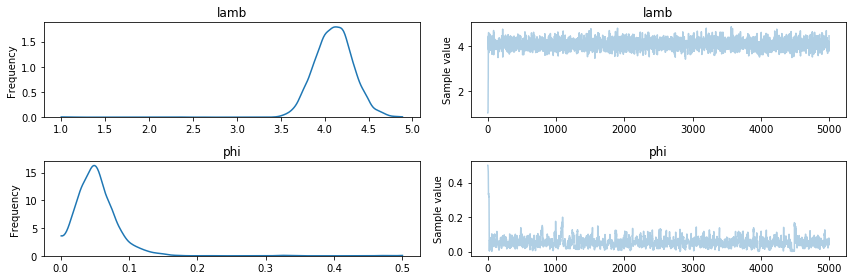

In [106]:
# fitted as a Zero-Inflated Poisson
with pm.Model() as ZIP_model:
    # vague priors for unknown model parameters
    lamb = pm.Gamma('lamb', alpha=0.001, beta=0.001)
    phi = pm.Beta('phi', alpha=1, beta=1)
    
    # likelihood
    Y_obs = pm.ZeroInflatedPoisson('Y_obs', theta=lamb, psi=1-phi, observed=data)
    
    # inference
    start_vals = {lamb: 1, phi: 0.5}
    zip_trace = pm.sample(draws=5000, start=start_vals, n_init=1000, progressbar=True)
    
    # visualize the trace
    plt.figure(figsize=(7, 7))
    pm.traceplot(zip_trace)
    plt.tight_layout()

#### c. Determine the Bayesian p-value for each model to test whether the distribution of the data that would arise from each model is in some way more extreme than the distribution of the observed data. To do this, you will need to determine $y^{new}$ in your code and estimate a test statistic. You can use the following test statistic:
$T(y,\theta)=\sum\left(\sqrt{y}-\sqrt{\bar y}\right)^2$

In [132]:
# posterior predictive checks, generate 2 Y_new observations along the trace
# sample_ppc resamples observed variable(s) along the chain using parameter values at each point
ppc_neg = pm.sample_ppc(trace=neg_trace[500:], model=negbinom_model, size=2)
ppc_pois = pm.sample_ppc(trace=pois_trace[500:], model=poisson_model, size=2)
ppc_zip = pm.sample_ppc(trace=zip_trace[500:], model=ZIP_model, size=2)

100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:23<00:00, 188.83it/s]


In [121]:
# generate test statistics comparing the 2 Y_new values in each model
neg_stat_1 = (np.sqrt(ppc_neg['Y_obs'][:,0])-np.sqrt(ppc_neg['Y_obs'][:,0].mean()))**2 # first Y_new
neg_stat_2 = (np.sqrt(ppc_neg['Y_obs'][:,1])-np.sqrt(ppc_neg['Y_obs'][:,1].mean()))**2 # second Y_new
pois_stat = ((np.sqrt(ppc_pois['Y_obs'])-np.sqrt(ppc_pois['Y_obs'].mean()))**2).sum()
zip_stat = ((np.sqrt(ppc_zip['Y_obs'])-np.sqrt(ppc_zip['Y_obs'].mean()))**2).sum()

In [136]:
ppc_neg['Y_obs'][0:10,:]

array([[ 2,  2],
       [10,  2],
       [ 3,  3],
       [ 4,  4],
       [ 0,  2],
       [ 6,  1],
       [ 3,  5],
       [ 1,  3],
       [ 8, 15],
       [12,  3]])

#### d. Create a table with the three models and the resulting Bayesian p-values. Are these results consistent with what you would expect given how you simulated the data?

### 4. Consider the N-mixture model from question 1. If you wanted to determine a measure of goodness-of-fit for the abundance component of the model (where we specified $N_i\sim Poisson(\lambda)$), how would you go about doing so? You do not need to code this, I am looking for a description of the process. In considering how you would go about this, think about how this might be different from the process in question 3. Describe any issues or challenges you see.

Because $N_i$ is not directly observed (i.e., it is a latent variable), it will be challenging to directly evalute goodness-of-fit as compared to evaluating the model's fit for count data observed at field plots. I would probably evaluate goodness-of-fit for $N_i$ indirectly by comparing the goodness-of-fit for $y_{it}$ based on different forms (distribution family and parameterizations) for $N_i$. It might be reasonable to preferentially select or more heavily weight samples for goodness-of-fit testing where detection probability is higher. This would mitigate the amount of variability introduced in observed outcomes due to factors other than local abundance. 